# Tests with implemting numba to some of the processing functions

> Ricardo Peres, 26.07.2022

Numba: A High Performance Python Compiler: https://numba.pydata.org
 



In [1]:
import numba
import numpy as np

import pylars
from pylars.processing.waveforms import waveform_processing
from pylars.processing.pulses import pulse_processing

/home/atp/rperes/software/PyLArS/pylars/processing/rawprocessor.py:3: TqdmExperimentalWarning: Using `tqdm.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm import tqdm


#### Fire up a processor and get waveforms

In [2]:
process = pylars.processing.rawprocessor.simple_processor(sigma_level=2, baseline_samples=50)
data_path = '/disk/gfs_atp/xenoscope/SiPMs/char_campaign/raw_data/run6/room_temp_21072022/LED_ON_300K_51_0V/Module0/LED_ON_300K_51_0V_Module_0_0.root'
process.load_raw_data(data_path, V = 49,T = 300, module = 0)

In [3]:
channel_data = process.raw_data.get_channel_data('wf0')
baseline = waveform_processing.get_baseline_rough(channel_data[0], 50)
std = waveform_processing.get_std_rough(channel_data[0], 50)
pks = pulse_processing.find_pulses_simple(np.array(channel_data[0]), baseline, std, 2)

## Test area functions

In [4]:
def get_area(waveform: np.ndarray, baseline_value: float,
             pulse_start: int, pulse_end: int, dt: int = 10) -> float:
    """Get area of a single identified pulse in a waveform.

    Args:
        waveform (_type_): _description_
        baseline_value (float): _description_
        pulse_start (int): _description_
        pulse_end (int): _description_
        dt (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """
    pulse_wf = waveform[pulse_start:pulse_end]
    area_under = np.sum(baseline_value - pulse_wf) * 10
    return area_under

@numba.njit
def get_area_numba(waveform: np.ndarray, baseline_value: float,
             pulse_start: int, pulse_end: int, dt: int = 10) -> float:
    """Get area of a single identified pulse in a waveform.

    Args:
        waveform (_type_): _description_
        baseline_value (float): _description_
        pulse_start (int): _description_
        pulse_end (int): _description_
        dt (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """
    pulse_wf = waveform[pulse_start:pulse_end]
    area_under = np.sum(baseline_value - pulse_wf) * 10
    return area_under

In [5]:
_pulse = pks[0]
_waveform = np.array(channel_data[0])

In [6]:
%%timeit
get_area(_waveform, baseline, _pulse[0], _pulse[-1])

5.52 µs ± 24.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
%%timeit
get_area_numba(_waveform, baseline, _pulse[0], _pulse[-1])

767 ns ± 1.41 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [8]:
def get_all_areas_normal(waveform: np.ndarray, pulses: np.ndarray, baseline_value: float) -> np.ndarray:
    """Compute the areas of all the pulses in a waveform.
    TO DO: use np.apply_along_axis or similar and see if
    there is speed improvement.
    """
    areas = np.zeros(len(pulses))
    for i, _pulse in enumerate(pulses):
        areas[i] = get_area(waveform, baseline_value, _pulse[0], _pulse[-1])
    return areas

def get_all_areas_list(waveform: np.ndarray, pulses: np.ndarray, baseline_value: float) -> list:
    """Compute the areas of all the pulses in a waveform.
    TO DO: use np.apply_along_axis or similar and see if
    there is speed improvement.
    """

    areas = [get_area(waveform, baseline_value, _pulse[0], _pulse[-1]) for _pulse in pulses]

    return areas

def get_all_areas_numba(waveform: np.ndarray, pulses: np.ndarray, baseline_value: float) -> np.ndarray:
    """Compute the areas of all the pulses in a waveform.
    TO DO: use np.apply_along_axis or similar and see if
    there is speed improvement.
    """
    areas = np.zeros(len(pulses))
    for i, _pulse in enumerate(pulses):
        areas[i] = get_area_numba(waveform, baseline_value, _pulse[0], _pulse[-1])
    return areas


In [9]:
%%timeit
areas = get_all_areas_normal(_waveform, pks, baseline)

23.6 µs ± 279 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%%timeit
areas = get_all_areas_list(_waveform, pks, baseline)

22.5 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%%timeit
areas = get_all_areas_numba(_waveform, pks, baseline)

3.27 µs ± 18.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Lengths

In [12]:
def get_all_lengths(pulses: list) -> list:
    """Compute the lengths of all the pulses in a waveform.
    """
    lengths = [len(_pulse) for _pulse in pulses]
    return lengths

@numba.njit
def get_all_lengths_numba(pulses: list) -> list:
    """Compute the lengths of all the pulses in a waveform.
    """
    lengths = [len(_pulse) for _pulse in pulses]
    return lengths

In [13]:
%%timeit
get_all_lengths(pks)

265 ns ± 0.534 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [14]:
%%timeit
get_all_lengths_numba(pks)

/disk/groups/atp/miniconda3/envs/sipms/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pulses' of function 'get_all_lengths_numba'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_73818/3553281082.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


28.9 µs ± 72.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Positions

In [15]:
def get_all_positions(pulses: list) -> list:
    """Calcultes the initial position of the identified pulse
    in number of samples.

    Args:
        pulses (_type_): array of identified pulses.

    Returns:
        _type_: list of positions of pulses.
    """
    positions = [_pulse[0] for _pulse in pulses]
    return positions

from numba.typed import List

@numba.njit
def get_all_positions_numba(pulses: list) -> list:
    """Calcultes the initial position of the identified pulse
    in number of samples.

    Args:
        pulses (_type_): array of identified pulses.

    Returns:
        _type_: list of positions of pulses.
    """
    positions = List()
    [positions.append(_pulse[0]) for _pulse in pulses]
    return positions

In [16]:
%%timeit
pos = get_all_positions(pks)

408 ns ± 0.599 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [17]:
%%timeit
pos_numba = get_all_positions_numba(pks)

/disk/groups/atp/miniconda3/envs/sipms/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pulses' of function 'get_all_positions_numba'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_73818/1025727561.py", line 16:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


44.8 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Split pulses

In [18]:
def split_consecutive_normal(array: np.array, stepsize: int = 1):
    split_index = np.where(np.diff(array) != stepsize)[0] + 1
    split_array = np.split(array, split_index)
    return split_array

@numba.njit
def split_consecutive_numba(array: np.array, stepsize: int = 1):
    split_index = np.where(np.diff(array) != stepsize)[0] + 1
    split_array = np.split(array, split_index)
    return split_array

def split_consecutive_kindapython(array: np.array, stepsize: int = 1):
    split_list = list()
    _running_list = list()
    for i, index_number_from_waveform in enumerate(array):
        if i==(len(array)-1):
            if index_number_from_waveform ==array[i-1]+1:
                _running_list.append(index_number_from_waveform)
                split_list.append(_running_list)
            else:
                split_list.append([index_number_from_waveform])
            break
        if index_number_from_waveform == (array[i+1]-1):
            _running_list.append(index_number_from_waveform)
        else:
            _running_list.append(index_number_from_waveform)
            split_list.append(_running_list)
            _running_list = list()
#    split_index = np.where(np.diff(array) != stepsize)[0] + 1
#    split_array = np.split(array, split_index)
    return split_list

In [19]:
bellow_baseline = np.where(_waveform < (baseline - std*1.5))[0]

In [20]:
%%timeit
split_array = split_consecutive_normal(bellow_baseline)

25.4 µs ± 55.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
split_array_numba = split_consecutive_numba(bellow_baseline)

75.2 µs ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
split_list = split_consecutive_kindapython(bellow_baseline)

26.1 µs ± 51.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Count number of pulses in waveform

In [23]:
import pandas as pd

df = pd.read_hdf('test_df.h5')
df = df.iloc[:10000]
print(len(df))

10000


In [24]:
wf_number_arr = df['wf_number'].values

In [25]:
def how_many1(df: pd.DataFrame) -> pd.DataFrame:
    ret = []
    waveforms_w_pulses = np.unique(df['wf_number'])
    n_waveforms = len(waveforms_w_pulses)
    for _wf in waveforms_w_pulses:
        n_pulses = len(df[df['wf_number'] == _wf])
        ret.append([_wf,n_pulses])
    return pd.DataFrame(ret, columns = ['wf_number', 'pulse_count'])

def how_many2(wf_number_list: np.ndarray) -> np.ndarray:
    waveforms_w_pulses = np.unique(wf_number_list)
    n_waveforms = len(waveforms_w_pulses)

    N_pulses = np.zeros(n_waveforms)

    for i, _wf in enumerate(waveforms_w_pulses):
        _n_pulses = np.count_nonzero(wf_number_list == _wf)
        N_pulses[i] = _n_pulses
    return waveforms_w_pulses, N_pulses

@numba.njit
def how_many2_numba(wf_number_list: np.ndarray) -> np.ndarray:
    waveforms_w_pulses = np.unique(wf_number_list)
    n_waveforms = len(waveforms_w_pulses)

    N_pulses = np.zeros(n_waveforms)

    for i, _wf in enumerate(waveforms_w_pulses):
        _n_pulses = np.count_nonzero(wf_number_list == _wf)
        N_pulses[i] = _n_pulses
    return waveforms_w_pulses, N_pulses


In [26]:
%%timeit
boop = how_many1(df)

65 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%%timeit
beep, boop = how_many2(wf_number_arr)

1.79 ms ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%%timeit
beep, boop = how_many2_numba(wf_number_arr)

1.05 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### some speed plots

In [29]:
import time
def time_count_process_1(df, n_entries):
    
    df = df.sample(n_entries, replace = True)
    t0 = time.time() 
    boop = how_many1(df)
    t1 = time.time()
    t_how_many1 = t1-t0

    return t_how_many1


def time_count_process_2(df, n_entries):
    
    df = df.sample(n_entries, replace = True)
    t0 = time.time() 
    wf_number_arr = df['wf_number'].values
    boop = how_many2(wf_number_arr)
    t1 = time.time()
    t_how_many2 = t1-t0
    
    return t_how_many2


def time_count_process_2_numba(df, n_entries):
    
    df = df.sample(n_entries, replace = True)
    t0 = time.time() 
    wf_number_arr = df['wf_number'].values
    beep, boop = how_many2_numba(wf_number_arr)
    t1 = time.time()
    t_how_many2_numba = t1-t0
    
    return t_how_many2_numba

In [30]:
_x = np.logspace(1,6,20)
t_1 = [time_count_process_1(df, int(_n)) for _n in _x]
t_2 = [time_count_process_2(df, int(_n)) for _n in _x]
t_2_numba = [time_count_process_2_numba(df, int(_n)) for _n in _x]

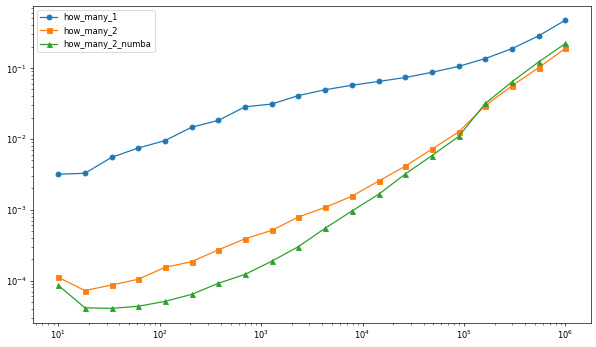

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7),dpi = 60)
plt.plot(_x, t_1, marker = 'o', label = 'how_many_1')
plt.plot(_x, t_2, marker = 's', label = 'how_many_2')
plt.plot(_x, t_2_numba, marker = '^', label = 'how_many_2_numba')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()